## Python Plotting With Matplotlib

In [1]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(444)

## The Matplotlib Object Hierarchy

matplotlib.figure.Figure

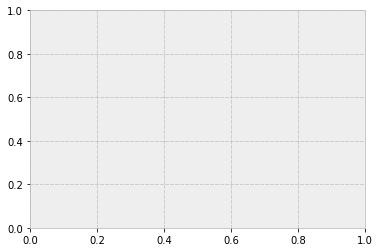

In [2]:
fig, _ = plt.subplots()
type(fig)

In [3]:
one_tick = fig.axes[0].yaxis.get_major_ticks()[0]
type(one_tick)

matplotlib.axis.YTick

In [4]:
len(fig.axes[0].xaxis.get_major_ticks()), len(fig.axes)

(6, 1)

## Stateful Versus Stateless Approaches

* The stateful interface makes its calls with `plt.plot()` and other top-level pyplot functions. There is only ever one `Figure` or `Axes` that you’re manipulating at a given time, and you don’t need to explicitly refer to it.
* Modifying the underlying objects directly is the object-oriented approach. We usually do this by calling methods of an `Axes` object, which is the object that represents a plot itself.
![](https://files.realpython.com/media/flow.a210eb81a42b.jpg)

Tying these together, most of the functions from `pyplot` also exist as methods of the `matplotlib.axes.Axes` class.

This is easier to see by peaking under the hood; `plt.plot()` can be boiled down to five or so lines of code:

In [5]:
def gca(**kwargs):
    """Get the current Axes of the current Figure."""
    return plt.gcf().gca(**kwargs)

def plot(*args, **kwargs):
    """An abridged version of plt.plot()."""
    ax = plt.gca()
    return ax.plot(*args, **kwargs)

That is, calling `plt.plot()` is just a convenient way to get the current Axes of the current Figure and then call its `plot()` method. This is what is meant by the assertion that the stateful interface always `implicitly tracks` the plot that it wants to reference.

pyplot is home to a batch of functions which are really just wrappers around matplotlib’s object-oriented interface. For example, with `plt.title()`, there are corresponding setter and getter methods within the OO approach, `ax.set_title()` and `ax.get_title()`

Calling `plt.title()` gets translated into this one line:

```python
gca().set_title(s, *args, **kwargs)
```
What is this doing?

* `gca()` grabs the current axis and returns it.
* `set_title()` is a setter method, which sets the title for that Axes object. The “convenience” here is that we didn’t need to specify any Axes object explicitly with `plt.title()`

Similarly, if you take a few moments to look at the source for top-level functions like `plt.grid()`, `plt.legend()`, and `plt.ylabels()`, you’ll notice that all of them follow the same structure of delegating to the current Axes with `gca()`, and then calling some method of the current Axes. (This is the underlying object-oriented approach!)

## Understanding `plt.subplots()` Notation

From here on out, **we’ll mostly rely on the stateless (object-oriented) approach**, which is more customizable and comes in handy as graphs become more complex.

The prescribed way to create a Figure with a single Axes under the OO approach is (not too intuitively) with `plt.subplots()`. (This is really the only time that the OO approach uses pyplot, to create a Figure and Axes).

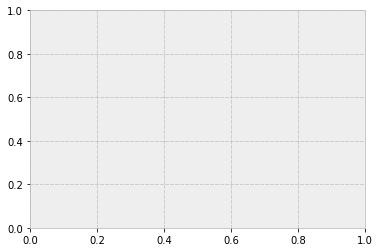

In [6]:
fig, ax = plt.subplots()

Above, we took advantage of iterable unpacking to assign a separate variable to each of the two results of `plt.subplots()`. Notice that we didn’t pass arguments to `subplots()` here; the default call is `subplots(nrows=1, ncols=1)`. Consequently, `ax` is a single `AxesSubplot` object:

In [7]:
type(ax)

matplotlib.axes._subplots.AxesSubplot

and we can call its **instance methods** to manipulate the plot similarly to how we call pyplots functions. Let’s illustrate with a stacked area graph of three time series:

In [8]:
rng = np.arange(50)
rnd = np.random.randint(0, 10, size=(3, rng.size))
yrs = 1950 + rng

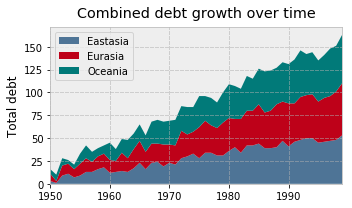

In [9]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.stackplot(yrs, rng + rnd, labels=['Eastasia', 'Eurasia', 'Oceania'])
ax.set_title('Combined debt growth over time')
ax.legend(loc='upper left')
ax.set_ylabel('Total debt')
ax.set_xlim(xmin=yrs[0], xmax=yrs[-1])
fig.tight_layout()

`tight_layout()` applies to the Figure object as a whole to clean up whitespace padding.

Let’s look at an example with **multiple subplots** (Axes) within one Figure, plotting two correlated arrays that are drawn from the discrete uniform distribution:

In [10]:
x = np.random.randint(low=1, high=11, size=50)
y = x + np.random.randint(1, 5, size=x.size)
data = np.column_stack((x, y))

In [11]:
data[:5,:]

array([[ 9, 11],
       [ 1,  5],
       [ 5,  6],
       [ 6,  7],
       [10, 14]])

In [12]:
np.arange(data.min(), data.max())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

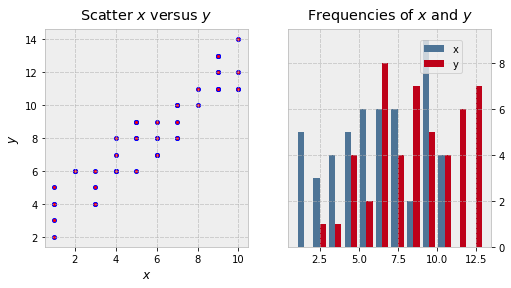

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

ax1.scatter(x=x, y=y, marker='o', c='r', edgecolor='b')
ax1.set_title('Scatter $x$ versus $y$')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')

ax2.hist(data, bins=np.arange(data.min(), data.max()), label=('x', 'y'))
ax2.legend(loc=(0.65, 0.8))
ax2.set_title('Frequencies of $x$ and $y$')
ax2.yaxis.tick_right()

In [17]:
(fig.axes[0] is ax1, fig.axes[1] is ax2)

(True, True)

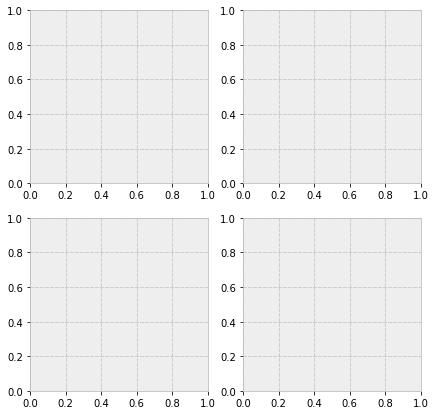

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))

In [26]:
type(ax)

numpy.ndarray

In [27]:
print(ax.shape)
ax

(2, 2)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114612400>,
      dtype=object)

`ax` can be either a single `matplotlib.axes.Axes` object or an array of `Axes` objects if more than one subplot was created.

We now need to call plotting methods on *each* of these `Axes` (not the NumPy array, which is just a container in this case). A common way to address this is to use **iterable unpacking** after *flattening* the array to be one-dimensional:

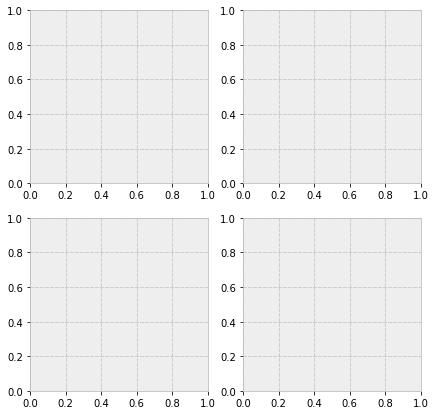

In [28]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))
ax1, ax2, ax3, ax4 = ax.flatten() # flatten a 2d NumPy array to 1d

We could’ve also done this with `((ax1, ax2), (ax3, ax4)) = ax`, but the first approach tends to be more flexible

#### macroeconomic California housing data

In [29]:
from io import BytesIO
import tarfile
from urllib.request import urlopen

In [35]:
url = 'http://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.tgz'
b = BytesIO(urlopen(url).read())
fpath = 'CaliforniaHousing/cal_housing.data'

In [36]:
with tarfile.open(mode='r', fileobj=b) as archive:
    housing = np.loadtxt(archive.extractfile(fpath), delimiter=',')

* The “response” variable `y` below, to use the statistical term, is an area’s average home value
* `pop` and `age` are the area’s population and average house age, respectively

In [43]:
y = housing[:, -1]
pop, age = housing[:, [4, 7]].T

Next let’s define a “helper function” that places a text box inside of a plot and acts as an “in-plot title”:

In [60]:
def add_titlebox(ax, text):
    ax.text(.55, .8, text,
            horizontalalignment='center',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.6),
            fontsize=12.5)
    return ax

We’re ready to do some plotting. Matplotlib’s `gridspec` module allows for more subplot customization. pyplot’s `subplot2grid()` interacts with this module nicely. 

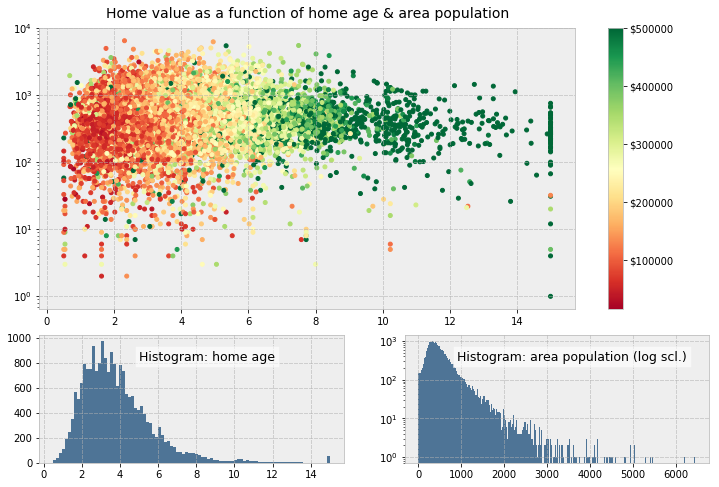

In [62]:
gridsize = (3, 2)
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid(gridsize, (2, 0))
ax3 = plt.subplot2grid(gridsize, (2, 1))

# Now, we can proceed as normal, modifying each Axes individually:
ax1.set_title('Home value as a function of home age & area population',
              fontsize=14)
sctr = ax1.scatter(x=age, y=pop, c=y, cmap='RdYlGn')
plt.colorbar(sctr, ax=ax1, format='$%d')
ax1.set_yscale('log')
ax2.hist(age, bins='auto')
ax3.hist(pop, bins='auto', log=True)
add_titlebox(ax2, 'Histogram: home age')
add_titlebox(ax3, 'Histogram: area population (log scl.)');

Above, `colorbar()` (different from `ColorMap` earlier) gets called on the Figure directly, rather than the Axes. Its first argument is the result of `ax1.scatter()`, which functions as a mapping of y-values to a ColorMap.

Visually, there isn’t much differentiation in color (the y-variable) as we move up-and-down the y-axis, indicating that home age seems to be a stonger determinant of house value.



## The “Figures” Behind The Scenes

Each time you call `plt.subplots()` or the lesser-used `plt.figure()` (which creates a Figure, with no Axes), you are creating a new Figure object that matplotlib sneakily keeps around in memory.

Earlier, we alluded to the concept of a current Figure and current Axes. By default, these are the most-recently-created Figure and Axes, which we can show with the builtin function `id()` to display the address of the object in memory

4706557232

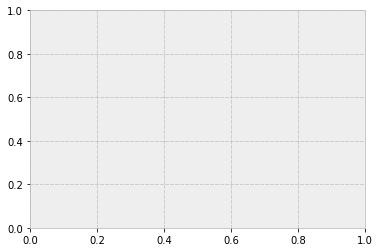

In [106]:
fig1, ax1 = plt.subplots()
id(fig1)

In [64]:
id(plt.gcf()) # `fig1` is the current figure

4710254408

<Figure size 432x288 with 0 Axes>

In [65]:
id(fig)

4716903448

In [66]:
id(ax1)

4726609288

True

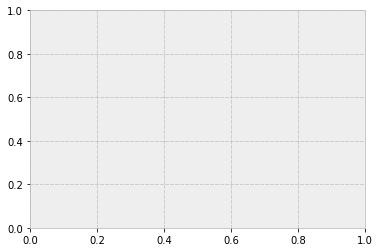

In [107]:
fig2, ax2 = plt.subplots()
#id(fig2) == id(plt.gcf()) # current figure has changed to `fig2`
plt.gcf() is fig2

In [108]:
plt.get_fignums()

[]

In [103]:
plt.close('all')

## A Burst Of Color: imshow() And matshow()

While `ax.plot()` is one of the most common plotting methods on an Axes, there are a whole host of others, as well. (We used `ax.stackplot()` above)

One group of methods that get heavy use are `imshow()` and `matshow()`, with the latter being a wrapper around the former. These are useful anytime that a raw numerical array an be visualized as a colored grid.

First, let’s create two distinct grids with some fancy NumPy indexing:

In [143]:
x = np.diag(np.arange(2, 12))[::-1]
x[np.diag_indices_from(x[::-1])] = np.arange(2, 12)
x2 = np.arange(x.size).reshape(x.shape)
x

array([[ 2,  0,  0,  0,  0,  0,  0,  0,  0, 11],
       [ 0,  3,  0,  0,  0,  0,  0,  0, 10,  0],
       [ 0,  0,  4,  0,  0,  0,  0,  9,  0,  0],
       [ 0,  0,  0,  5,  0,  0,  8,  0,  0,  0],
       [ 0,  0,  0,  0,  6,  7,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  6,  7,  0,  0,  0,  0],
       [ 0,  0,  0,  5,  0,  0,  8,  0,  0,  0],
       [ 0,  0,  4,  0,  0,  0,  0,  9,  0,  0],
       [ 0,  3,  0,  0,  0,  0,  0,  0, 10,  0],
       [ 2,  0,  0,  0,  0,  0,  0,  0,  0, 11]])

In [144]:
x2

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
       [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])

Next, we can map these to their image representations. In this specific case, we toggle “off” all axis labels and ticks by using a dictionary comprehension and passing the result to `ax.tick_params()`:

In [138]:
sides = ('left', 'right', 'top', 'bottom')
nolabels = {s: False for s in sides}
nolabels.update({'label%s' % s: False for s in sides})
print(nolabels)

{'left': False, 'right': False, 'top': False, 'bottom': False, 'labelleft': False, 'labelright': False, 'labeltop': False, 'labelbottom': False}


Then, we can use a `context manager` to disable the grid, and call `matshow()` on each Axes.

Lastly, we need to put the colorbar in what is technically a new Axes within `fig`. For this we can use a bit of an esoteric function from deep within matplotlib:

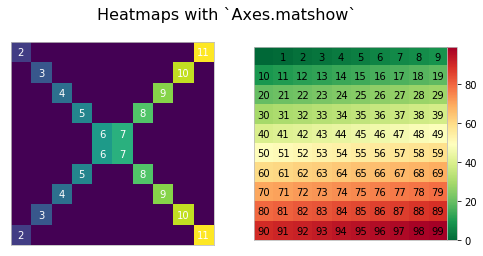

In [169]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

with plt.rc_context(rc={'axes.grid': False}):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.matshow(x)
    img2 = ax2.matshow(x2, cmap='RdYlGn_r')
    for ax in (ax1, ax2):
        ax.tick_params(axis='both', which='both', **nolabels)
    for i, j in zip(*x.nonzero()):
        ax1.text(j, i, x[i, j], color='white', ha='center', va='center')
        
    for i, j in zip(*x2.nonzero()):
        ax2.text(j, i, x2[i, j], color='black', ha='center', va='center')
        
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0)
    plt.colorbar(img2, cax=cax, ax=[ax1, ax2])
    fig.suptitle('Heatmaps with `Axes.matshow`', fontsize=16)

## Plotting In Pandas

Pandas plotting methods are really just convenient `wrappers` around existing matplotlib calls.

That is, the `plot()` method on pandas’ Series and DataFrame is a wrapper around `plt.plot()`. One convenience provided, for example, is that if the DataFrame’s Index consists of dates, `gcf().autofmt_xdate()` is called internally by pandas to get the current Figure and nicely auto-format the x-axis.

In turn, remember that `plt.plot()` (the state-based approach) is implicitly aware of the current Figure and current Axes, so pandas is following the state-based approach by extension.

We can prove this “chain” of function calls with a bit of introspection. First, let’s construct a plain-vanilla pandas Series, assuming we’re starting out in a fresh interpreter session:

<class 'matplotlib.axes._subplots.AxesSubplot'>
True


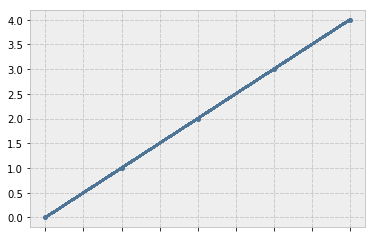

In [176]:
import pandas as pd

s = pd.Series(np.arange(5), index=list('abcde'))
ax = s.plot()
print(type(ax))
print(ax is plt.gca())

This internal architecture is helpful to know **when you are mixing** pandas plotting methods with traditional matplotlib calls, which is done below in plotting the moving average of a widely-watched financial time series. 

`ma` is a pandas Series for which we can call `ma.plot()` (the pandas method), and then customize by retrieving the Axes that is created by this call (`plt.gca()`), for matplotlib to reference.

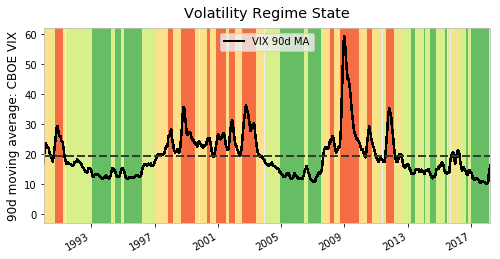

In [196]:
import pandas as pd
import matplotlib.transforms as mtransforms

url = 'https://fred.stlouisfed.org/graph/fredgraph.csv?id=VIXCLS'
vix = pd.read_csv(url, index_col=0, parse_dates=True, na_values='.',
                  infer_datetime_format=True,
                  squeeze=True).dropna()
ma = vix.rolling('90d').mean()
state = pd.cut(ma, bins=[-np.inf, 14, 18, 24, np.inf], labels=range(4))

cmap = plt.get_cmap('RdYlGn_r')
ma.plot(color='black', linewidth=1.5, marker='',
        figsize=(8, 4), label='VIX 90d MA')

ax = plt.gca() # get the current Axes that ma.plot() references
ax.set_xlabel('')
ax.set_ylabel('90d moving average: CBOE VIX')
ax.set_title('Volatility Regime State')
ax.grid(False)
ax.legend(loc='upper center')
ax.set_xlim(xmin=ma.index[0], xmax=ma.index[-1])

trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
for i, color in enumerate(cmap([0.2, 0.4, 0.6, 0.8])):
    ax.fill_between(ma.index, 0, 1, where=state==i,
                    facecolor=color, transform=trans)
    ax.axhline(vix.mean(), linestyle='dashed', color='xkcd:dark grey',
               alpha=0.6, label='Full-period mean', marker='')

There’s a lot happening above:

* `ma` is a 90-day moving average of the VIX Index, a measure of market expectations of near-term stock volatility. `state` is a binning of the moving average into different regime states; a high VIX is seen as signaling a heightened level of fear in the marketplace.
* `cmap` is a ColorMap–a matplotlib object that is essentially a mapping of floats to RGBA colors. Any colormap can be reversed by appending '`_r`', so '`RdYlGn_r`' is the reversed Red-Yellow-Green colormap. Matplotlib maintains a handy **visual reference guide** to colormaps in its docs.
* The only real pandas call we’re making here is `ma.plot()`. This calls `plt.plot()` internally, so to integrate the object-oriented approach, we need to get an explicit reference to the current Axes with `ax = plt.gca()`
* The second chunk of code creates color-filled blocks that correspond to each bin of `state`. `cmap([0.2, 0.4, 0.6, 0.8])` says, “get us an RGBA sequence for the colors at the 20th, 40th, 60th, and 80th ‘percentile’ along the colormaps’s spectrum.” **enumerate()** is used because we want to map each RGBA color back to a state.

Pandas also comes built-out with a smattering of *more advanced plots* (which could take up an entire tutorial all on their own). However, all of these, like their simpler counterparts, rely on matplotlib machinery internally.